In [1]:
import cv2
import os
from operator import itemgetter
from numpy import array
import csv
import time
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import datetime

In [2]:
# imports all the images from a specified folder, with a specific extension
# and resizes to a specific imgHeight, imgWidth

def import_dataset(path, mode, fileExtension='.jpg', imgWidth=224, imgHeight=224):
    datasetFilenamesImages = []
    dataset = []
    print("Start importing " + mode + " images...")
    for filename in os.listdir(path):
        if filename.endswith(fileExtension): 
            completePath = os.path.join(path, filename)
            image = cv2.imread(completePath, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, dsize=(imgHeight, imgWidth), interpolation=cv2.INTER_AREA)
            filenameImage = [filename, image]
            datasetFilenamesImages.append(filenameImage)
        else:
            continue
    
    datasetFilenamesImages = sorted(datasetFilenamesImages, key=itemgetter(0))
    for x in datasetFilenamesImages:
        dataset.append(x[1])
    
    return array(dataset)
    

In [3]:
# returns a counter with the number of samples for each class
# returns a list of the true labels
# Assumptions: 1st row is headers definition, True Labels are sorted by the image filename in the csv

def assign_labels(pathGroundtruth):
    target = []
    counter = {'MEL': 0, 'NV': 0, 'BCC': 0, 'AKIEC': 0, 'BKL': 0, 'DF': 0, 'VASC': 0}
    i = 0
    with open(pathGroundtruth, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            if i == 0: # headers
                i += 1
                continue
            if row[1] == '1.0':  # MEL
                counter['MEL'] += 1
                target.append(0)
            elif row[2] == '1.0':  # NV
                counter['NV'] += 1
                target.append(1)
            elif row[3] == '1.0':  # BCC
                counter['BCC'] += 1
                target.append(2)
            elif row[4] == '1.0':  # AKIEC
                counter['AKIEC'] += 1
                target.append(3)
            elif row[5] == '1.0':  # BKL
                counter['BKL'] += 1
                target.append(4)
            elif row[6] == '1.0':  # DF
                counter['DF'] += 1
                target.append(5)
            elif row[7] == '1.0':  # VASC
                counter['VASC'] += 1
                target.append(6)  # BCC
            else:
                continue
        print(counter)
        file.close()
        return counter, target
        

In [4]:
def plot_val_train_error(fit):
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.grid(True)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.grid(True)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [5]:
def create_model(model='densenet', transferLearning=True, imgWidth=224, imgHeight = 224):
    if model == 'resnet':

        from tensorflow.keras.applications.resnet import ResNet101
        from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

        if transferLearning == False:
            resnet = ResNet101(include_top=False, weights=None, input_shape=(imgHeight, imgWidth, 3))
        else:
            resnet = ResNet101(include_top=False, weights='imagenet', input_shape=(imgHeight, imgWidth, 3))

        model = tf.keras.Sequential(resnet)
        model.add(GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(Dense(units=7, activation="softmax"))

    elif model == 'densenet':

        from tensorflow.keras.applications.densenet import DenseNet121
        from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

        if transferLearning == False:
            densenet = DenseNet121(include_top=False, weights=None, input_shape=(imgHeight, imgWidth, 3))
        else:
            densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(imgHeight, imgWidth, 3))

        model = tf.keras.Sequential(densenet)
        model.add(GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(Dense(units=7, activation="softmax"))
    
    return model

In [6]:
# Learning Rate Scheduler

def scheduler(epoch):
    global noEpochs
    global learningRate
    if epoch < int(0.5 * noEpochs):
        return learningRate
    elif epoch < int(0.75 * noEpochs):
        return learningRate / 10
    else:
        return learningRate / 100

In [7]:
# Import Training and Validation datasets and Groundtruth

pathTrain = '/home/ruben/Desktop/isic_2018/train_2018'
truthTrain = '/home/ruben/Desktop/isic_2018/train_2018/labels.csv'

x_train = import_dataset(pathTrain, 'training')
counterTrain, y_train = assign_labels(truthTrain)

pathVal = '/home/ruben/Desktop/isic_2018/val_2018'
truthVal = '/home/ruben/Desktop/isic_2018/val_2018/labels.csv'

x_val = import_dataset(pathVal, 'validation')
counterVal, y_val = assign_labels(truthVal)

print("Dataset Imported")

Start importing training images...
{'MEL': 3, 'NV': 3, 'BCC': 3, 'AKIEC': 3, 'BKL': 3, 'DF': 3, 'VASC': 3}
Start importing validation images...
{'MEL': 1, 'NV': 1, 'BCC': 1, 'AKIEC': 1, 'BKL': 1, 'DF': 1, 'VASC': 1}
Dataset Imported


In [8]:
# Define training variables

noEpochs = 5
learningRate = 1e-5
noClasses = 7
batchSize = 10
modelName = 'densenet'

checkpointPath = {
    'resnet': "/home/ruben/Desktop/isic_2018/model_weights/flat/resnet/cp.ckpt",
    'densenet': "/home/ruben/Desktop/isic_2018/model_weights/flat/densenet/cp.ckpt"
}

# Define the class weights to handle unbalanced dataset

w_0 = 10608. / 1212
w_1 = 10608. / 7149
w_2 = 10608. / 519
w_3 = 10608. / 360
w_4 = 10608. / 1101
w_5 = 10608. / 114
w_6 = 10608. / 153

classWeights = {0: w_0, 1: w_1, 2: w_2, 3: w_3, 4: w_4, 5: w_5, 6: w_6}

y_train_cat = keras.utils.to_categorical(y_train, noClasses)
y_val_cat = keras.utils.to_categorical(y_val, noClasses)

# Callback to adapt the learning rate value
schedulerLearningRate = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Callback to save the Best Model Weights
checkpoint_dir = os.path.dirname(checkpointPath[modelName])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpointPath[modelName],
    save_weights_only=True,
    verbose=1, 
    save_best_only=True
)

In [9]:
# Create and fit the model
model = create_model(modelName, transferLearning=True)
model.summary()

model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(lr=1e-5),
    metrics = ['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 7175      
Total params: 7,044,679
Trainable params: 6,961,031
Non-trainable params: 83,648
_________________________________________________________________


In [13]:
fit = model.fit(
    x_train,
    y_train_cat,
    batch_size=batchSize,
    class_weight=classWeights,
    callbacks=[schedulerLearningRate, checkpoint],
    epochs = noEpochs,
    shuffle=True,
    validation_data=(x_val, y_val_cat)
)

plot_val_train_error(fit)

Epoch 1/5
3/3 [==============================] - ETA: 0s - loss: 54.3230 - accuracy: 0.2381
Epoch 00001: val_loss improved from 2.09207 to 2.08688, saving model to /home/ruben/Desktop/isic_2018/model_weights/flat/densenet/cp.ckpt
3/3 [==============================] - 7s 2s/step - loss: 54.3230 - accuracy: 0.2381 - val_loss: 2.0869 - val_accuracy: 0.1429 - lr: 1.0000e-05
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 55.5157 - accuracy: 0.2857
Epoch 00002: val_loss improved from 2.08688 to 2.07504, saving model to /home/ruben/Desktop/isic_2018/model_weights/flat/densenet/cp.ckpt
3/3 [==============================] - 10s 3s/step - loss: 55.5157 - accuracy: 0.2857 - val_loss: 2.0750 - val_accuracy: 0.1429 - lr: 1.0000e-05
Epoch 3/5
3/3 [==============================] - ETA: 0s - loss: 51.7485 - accuracy: 0.3333
Epoch 00003: val_loss did not improve from 2.07504
3/3 [==============================] - 8s 3s/step - loss: 51.7485 - accuracy: 0.3333 - val_loss: 2.0776 - va

[[0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0]]
1/1 [==============================] - 0s 5ms/step - loss: 2.0668 - accuracy: 0.1429
Test loss: 2.066800117492676 / Test accuracy: 0.1428571492433548


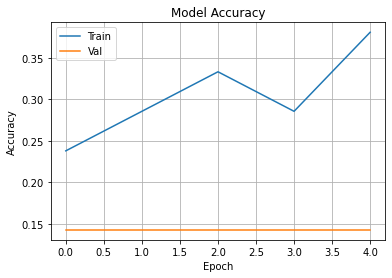

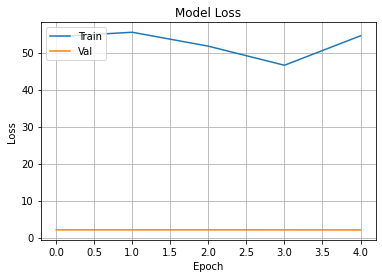

In [14]:
# Inference in test_set
model.load_weights(checkpointPath[modelName])

y_pred = model.predict_classes(x_val)
conf_matrix = confusion_matrix(y_val, y_pred)
print(conf_matrix)

score = model.evaluate(x_val, y_val_cat, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
